In [76]:
import re
import numpy as np
import seaborn as sns
import os
import pandas as pd
import sklearn as sk
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import scipy
from scipy.stats import t
from sklearn.manifold import TSNE
import time

In [62]:
print(os.listdir(), '\n', os.getcwd())

with open('plot_time.csv', 'r') as init_data:
    raw_data = pd.read_csv(init_data)

['.git', '.gitattributes', '.ipynb_checkpoints', 'big_MCI_plot.png', 'data_analysis_script.py', 'DX_bl_big_MCI_plot.png', 'EDA.ipynb', 'eda2.ipynb', 'plot_time.csv', 'prelim data analysis.py', 'PTGENDER_big_MCI_plot.png', 'simple_data.csv', 'Stats.ipynb', 'TADPOLE_D1_D2.csv', 'TADPOLE_D1_D2.py', 'TADPOLE_D1_D2_Dict.csv', 'TADPOLE_D2.m', 'TADPOLE_D3.csv', 'TADPOLE_D3.m', 'TADPOLE_readme.txt'] 
 C:\Users\tnank\Documents\GitHub\Project-daybreak


In [63]:
patients = raw_data.loc[:,"RID"].unique()

changers = np.zeros(len(patients))
impaired = np.zeros(len(patients))

cata = pd.DataFrame(patients)
cata["change"] = changers
cata["impaired"] = impaired
cata.rename(columns={0:"RID"}, inplace=True)

for i,v in enumerate(cata.loc[:,"RID"]):
    vals = raw_data.loc[raw_data["RID"] == v, ["DX_bl", "DXCHANGE"]]
    if sum(vals.DXCHANGE > 3) > 0:
        cata.loc[i, "change"] = 1
    if ((vals.DX_bl.any() != "CN") | sum(vals.DXCHANGE > 1) > 0):
        cata.loc[i, "impaired"] = 1      
merge = pd.merge(raw_data, cata, on="RID", how="outer")       

In [64]:
merge.PTGENDER = merge.PTGENDER.astype("category")
merge.PTMARRY = merge.PTMARRY.astype("category")
merge.PTETHCAT = merge.PTETHCAT.astype("category")
merge.PTRACCAT = merge.PTRACCAT.astype("category")
merge.change = merge.change.astype("category")
merge.impaired = merge.impaired.astype("category")


In [65]:
merge.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12741 entries, 0 to 12740
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Unnamed: 0                  12741 non-null  int64   
 1   RID                         12741 non-null  int64   
 2   EXAMDATE                    12741 non-null  object  
 3   DX_bl                       12741 non-null  object  
 4   AGE                         12741 non-null  float64 
 5   PTGENDER                    12741 non-null  category
 6   PTEDUCAT                    12741 non-null  int64   
 7   PTETHCAT                    12741 non-null  category
 8   PTRACCAT                    12741 non-null  category
 9   PTMARRY                     12741 non-null  category
 10  APOE4                       12729 non-null  float64 
 11  EXAMDATE_bl                 12741 non-null  object  
 12  CDRSB_bl                    12741 non-null  float64 
 13  ADAS11_bl       

In [68]:
filled = merge.copy()
filled.head()

,Unnamed: 0,RID,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,...,Entorhinal,MidTemp,FDG,AV45,ABETA_UPENNBIOMK9_04_19_17,TAU_UPENNBIOMK9_04_19_17,PTAU_UPENNBIOMK9_04_19_17,VISNUMS,change,impaired
0,0,2,2005-09-08,CN,74.3,Male,16,Not Hisp/Latino,White,Married,...,4177.0,27936.0,1.36926,NaN,NaN,NaN,NaN,0,1.0,1.0
1,5723,2,2006-03-06,CN,74.3,Male,16,Not Hisp/Latino,White,Married,...,NaN,NaN,1.21655,NaN,NaN,NaN,NaN,6,1.0,1.0
2,5724,2,2008-08-27,CN,74.3,Male,16,Not Hisp/Latino,White,Married,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,1.0,1.0
3,5725,2,2010-09-22,CN,74.3,Male,16,Not Hisp/Latino,White,Married,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60,1.0,1.0
4,5726,2,2011-03-04,CN,74.3,Male,16,Not Hisp/Latino,White,Married,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66,1.0,1.0


In [78]:
tic = time.perf_counter()
fill4 = filled.fillna(filled.groupby('RID').transform('mean'))
toc = time.perf_counter()
print(toc-tic)
fill4.loc[fill4.RID==2,:]

13.842740799998865


,Unnamed: 0,RID,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,...,Entorhinal,MidTemp,FDG,AV45,ABETA_UPENNBIOMK9_04_19_17,TAU_UPENNBIOMK9_04_19_17,PTAU_UPENNBIOMK9_04_19_17,VISNUMS,change,impaired
0,0,2,2005-09-08,CN,74.3,Male,16,Not Hisp/Latino,White,Married,...,4177.0,27936.0,1.369260,NaN,NaN,NaN,NaN,0,1.0,1.0
1,5723,2,2006-03-06,CN,74.3,Male,16,Not Hisp/Latino,White,Married,...,4177.0,27936.0,1.216550,NaN,NaN,NaN,NaN,6,1.0,1.0
2,5724,2,2008-08-27,CN,74.3,Male,16,Not Hisp/Latino,White,Married,...,4177.0,27936.0,1.292905,NaN,NaN,NaN,NaN,36,1.0,1.0
3,5725,2,2010-09-22,CN,74.3,Male,16,Not Hisp/Latino,White,Married,...,4177.0,27936.0,1.292905,NaN,NaN,NaN,NaN,60,1.0,1.0
4,5726,2,2011-03-04,CN,74.3,Male,16,Not Hisp/Latino,White,Married,...,4177.0,27936.0,1.292905,NaN,NaN,NaN,NaN,66,1.0,1.0
5,5727,2,2011-09-19,CN,74.3,Male,16,Not Hisp/Latino,White,Married,...,4177.0,27936.0,1.292905,NaN,NaN,NaN,NaN,72,1.0,1.0
6,5728,2,2012-03-22,CN,74.3,Male,16,Not Hisp/Latino,White,Married,...,4177.0,27936.0,1.292905,NaN,NaN,NaN,NaN,78,1.0,1.0
7,5729,2,2012-09-26,CN,74.3,Male,16,Not Hisp/Latino,White,Married,...,4177.0,27936.0,1.292905,NaN,NaN,NaN,NaN,84,1.0,1.0
8,5730,2,2013-03-25,CN,74.3,Male,16,Not Hisp/Latino,White,Married,...,4177.0,27936.0,1.292905,NaN,NaN,NaN,NaN,90,1.0,1.0
9,5731,2,2013-09-09,CN,74.3,Male,16,Not Hisp/Latino,White,Married,...,4177.0,27936.0,1.292905,NaN,NaN,NaN,NaN,96,1.0,1.0


In [79]:
#tic = time.perf_counter()
#for c,v in enumerate(merge.RID.unique()):
#    filled.loc[filled.RID == v, :] = filled.loc[filled.RID == v, :].fillna(filled.loc[filled.RID == v, :].mean())

#toc = time.perf_counter()
#print(toc-tic)
#filled.info()

97.1858261999987


decision tree 1st
boosting 2nd
k nearest neighbour
gaussian biased model 

finally ensemble method.

In [51]:
pts = merge.groupby("RID")
pts_mean = pts.mean()
fill2 = merge.combine_first(pts_mean)
fill3 = pd.merge(merge, pts_mean, on="RID", how="outer")
#merge.info()
#fill2.info()

m2 = merge.loc[merge.RID==2,:]
f2 = fill2.loc[fill2.RID==2,:]
f3 = fill3.loc[fill3.RID==2,:]


print(m2.FDG)
print(f2.FDG)
print(f3.loc[:,["FDG_x", "FDG_y"]])
print(filled.loc[filled.RID==2,"FDG"])
print(fill3.info())




0     1.36926
1     1.21655
2         NaN
3         NaN
4         NaN
5         NaN
6         NaN
7         NaN
8         NaN
9         NaN
10        NaN
11        NaN
12        NaN
Name: FDG, dtype: float64
0     1.369260
1     1.216550
2     1.292905
3     1.074235
4          NaN
5     1.319690
6          NaN
7          NaN
8     1.264300
9          NaN
10    1.042469
11         NaN
12         NaN
Name: FDG, dtype: float64
      FDG_x     FDG_y
0   1.36926  1.292905
1   1.21655  1.292905
2       NaN  1.292905
3       NaN  1.292905
4       NaN  1.292905
5       NaN  1.292905
6       NaN  1.292905
7       NaN  1.292905
8       NaN  1.292905
9       NaN  1.292905
10      NaN  1.292905
11      NaN  1.292905
12      NaN  1.292905
0     1.369260
1     1.216550
2     1.292905
3     1.292905
4     1.292905
5     1.292905
6     1.292905
7     1.292905
8     1.292905
9     1.292905
10    1.292905
11    1.292905
12    1.292905
Name: FDG, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Int6

In [52]:
filled.loc[filled.RID==2,"FDG"]

0     1.369260
1     1.216550
2     1.292905
3     1.292905
4     1.292905
5     1.292905
6     1.292905
7     1.292905
8     1.292905
9     1.292905
10    1.292905
11    1.292905
12    1.292905
Name: FDG, dtype: float64

In [53]:
#for c,v in enumerate(merge.columns):
#    print(c,v)
features = [4, 5, 10, 12, 13, 15, 16, 17, 21, 22, 24, 25, 26, 27, 35, 37, 43, 44, 45]
target = 48

In [54]:
len(features)

19

In [55]:
x = fill4.iloc[:,features]
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12741 entries, 0 to 12740
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   AGE                         12741 non-null  float64 
 1   PTGENDER                    12741 non-null  category
 2   APOE4                       12729 non-null  float64 
 3   CDRSB_bl                    12741 non-null  float64 
 4   ADAS11_bl                   12724 non-null  float64 
 5   MMSE_bl                     12741 non-null  int64   
 6   RAVLT_immediate_bl          12705 non-null  float64 
 7   RAVLT_learning_bl           12705 non-null  float64 
 8   Ventricles_bl               12251 non-null  float64 
 9   Hippocampus_bl              10960 non-null  float64 
 10  Entorhinal_bl               10847 non-null  float64 
 11  Fusiform_bl                 10847 non-null  float64 
 12  MidTemp_bl                  10847 non-null  float64 
 13  ICV_bl          

In [56]:
t1 = x.copy()
t1["rid"] =  filled.RID
t1["impaired"] = filled.impaired
t1["female"] = 1
t1.loc[t1.PTGENDER == "Male","female"] = 0
t1 = t1.drop("PTGENDER", axis=1)
t1.impaired = t1.impaired.astype("int")
t2 = t1.dropna()
t2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7302 entries, 13 to 12740
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AGE                         7302 non-null   float64
 1   APOE4                       7302 non-null   float64
 2   CDRSB_bl                    7302 non-null   float64
 3   ADAS11_bl                   7302 non-null   float64
 4   MMSE_bl                     7302 non-null   int64  
 5   RAVLT_immediate_bl          7302 non-null   float64
 6   RAVLT_learning_bl           7302 non-null   float64
 7   Ventricles_bl               7302 non-null   float64
 8   Hippocampus_bl              7302 non-null   float64
 9   Entorhinal_bl               7302 non-null   float64
 10  Fusiform_bl                 7302 non-null   float64
 11  MidTemp_bl                  7302 non-null   float64
 12  ICV_bl                      7302 non-null   float64
 13  MMSE                        730

In [57]:

ts = t2.groupby("impaired")
ts.count()

,AGE,APOE4,CDRSB_bl,ADAS11_bl,MMSE_bl,RAVLT_immediate_bl,RAVLT_learning_bl,Ventricles_bl,Hippocampus_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,MMSE,Hippocampus,ABETA_UPENNBIOMK9_04_19_17,TAU_UPENNBIOMK9_04_19_17,PTAU_UPENNBIOMK9_04_19_17,rid,female
impaired,,,,,,,,,,,,,,,,,,,,
0,1542,1542,1542,1542,1542,1542,1542,1542,1542,1542,1542,1542,1542,1542,1542,1542,1542,1542,1542,1542
1,5760,5760,5760,5760,5760,5760,5760,5760,5760,5760,5760,5760,5760,5760,5760,5760,5760,5760,5760,5760


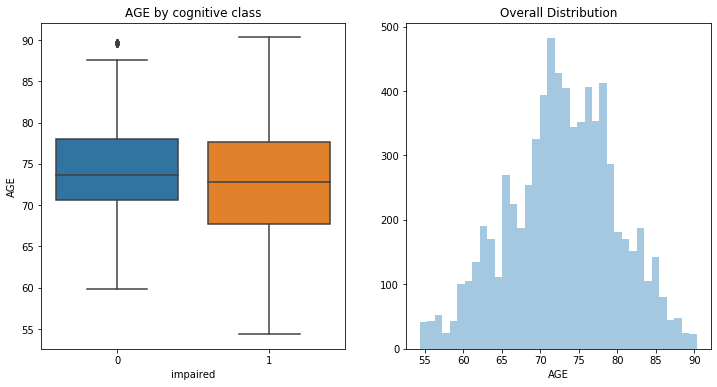

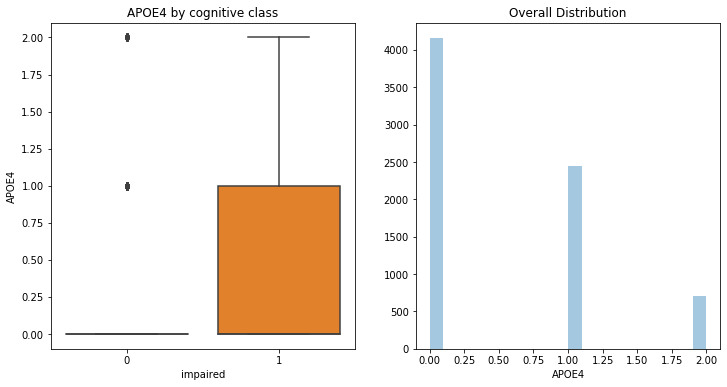

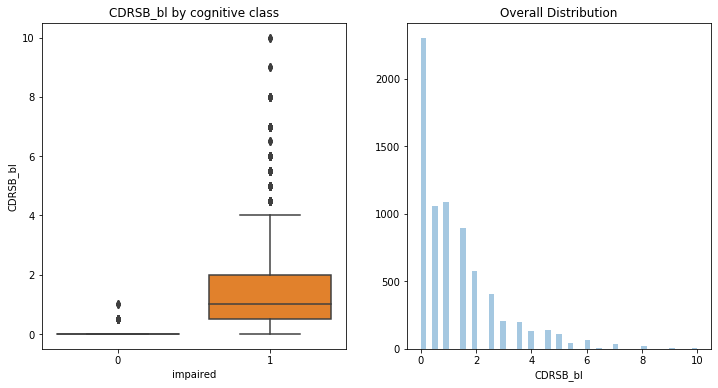

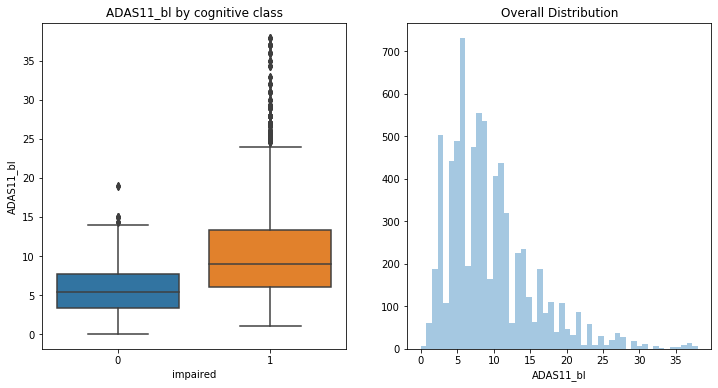

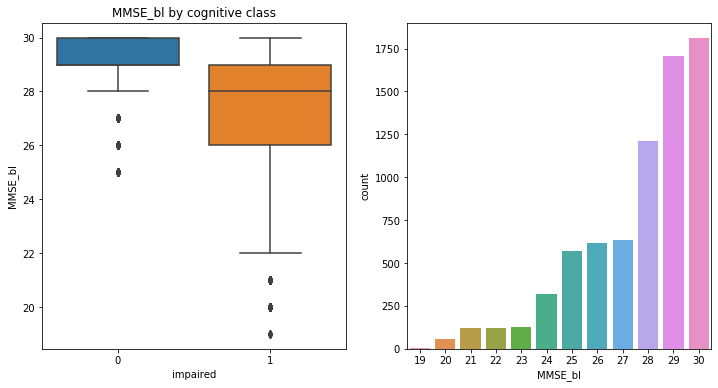

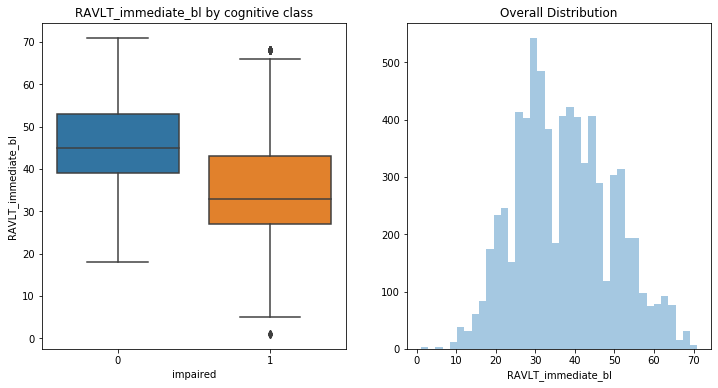

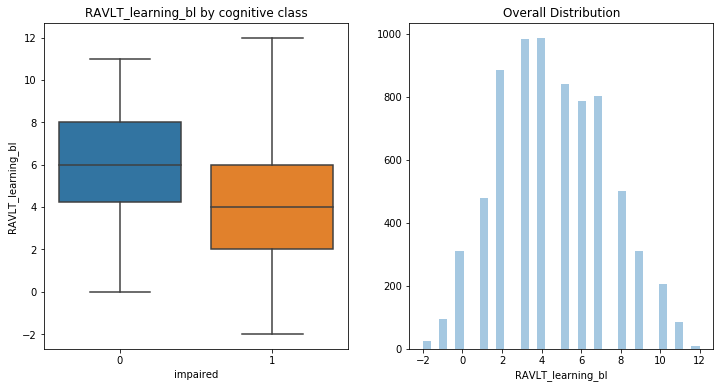

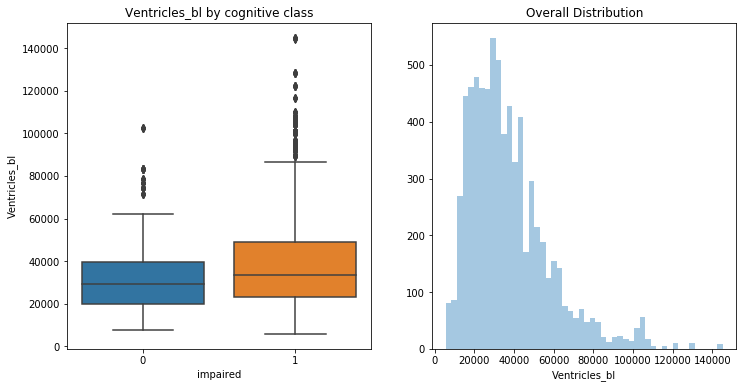

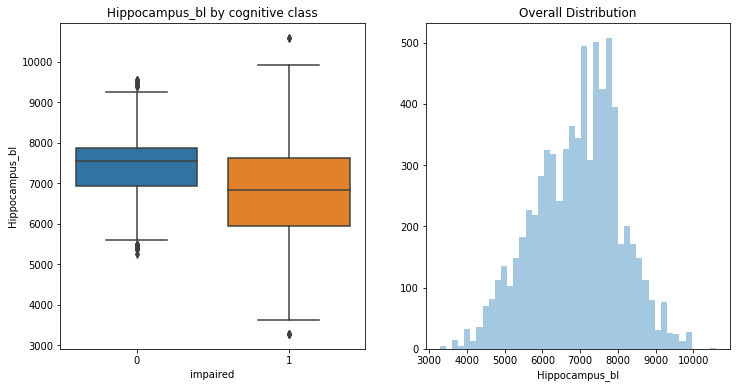

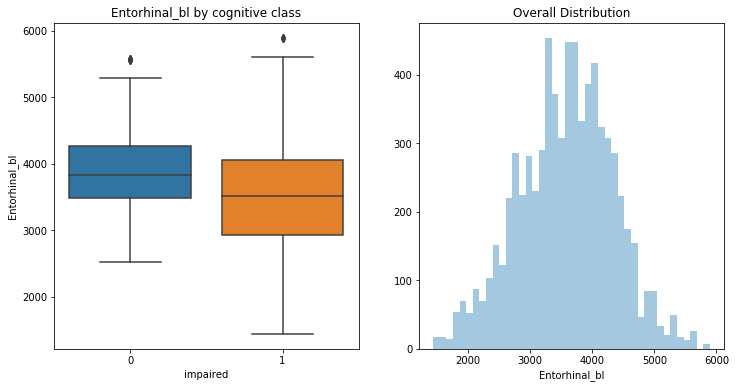

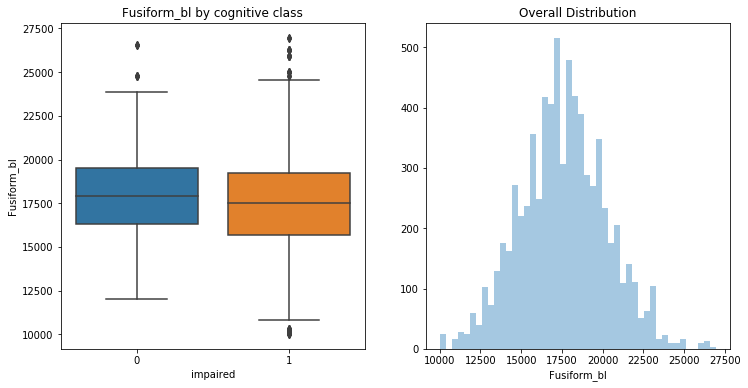

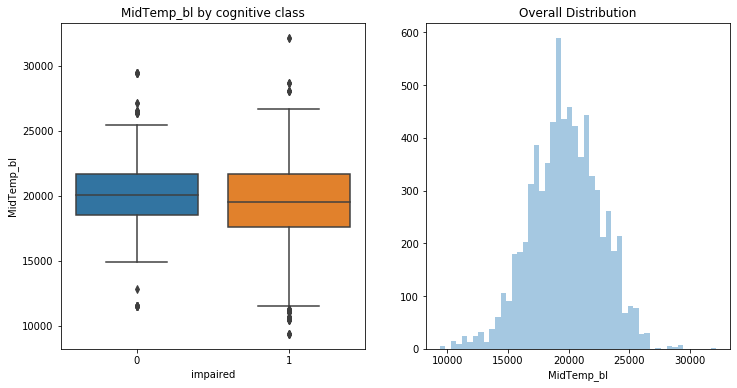

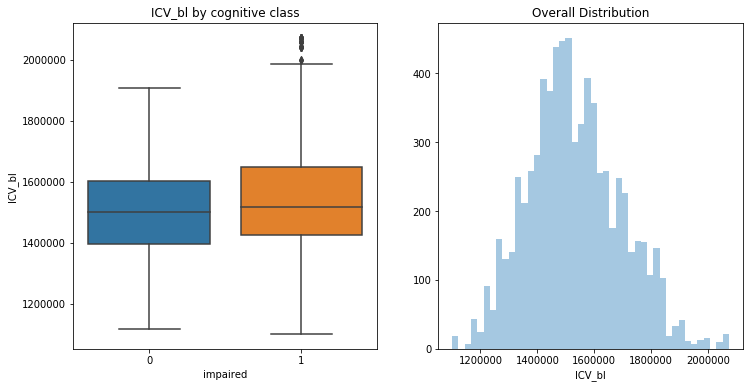

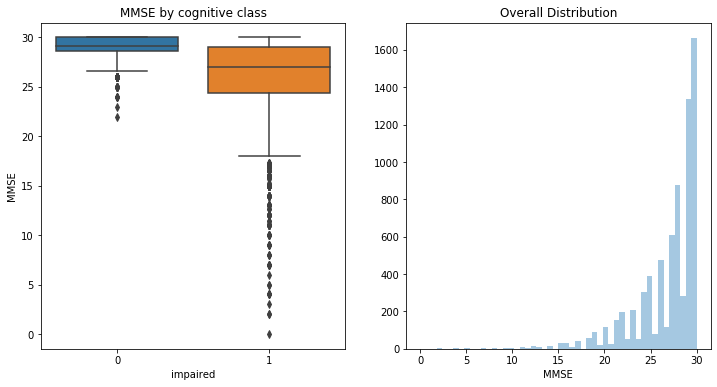

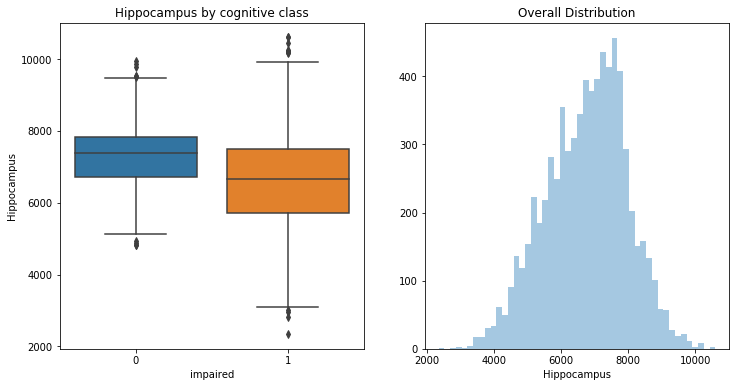

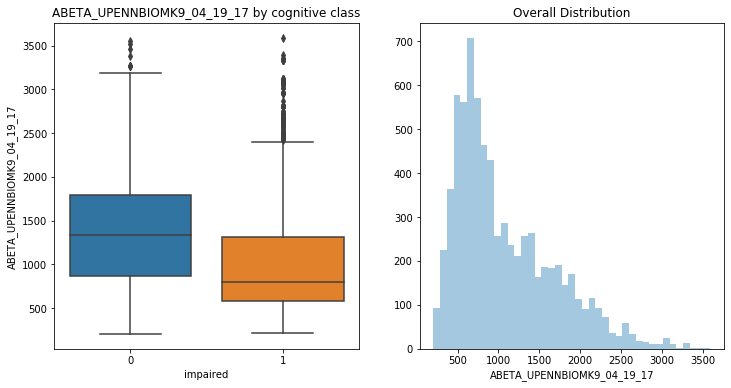

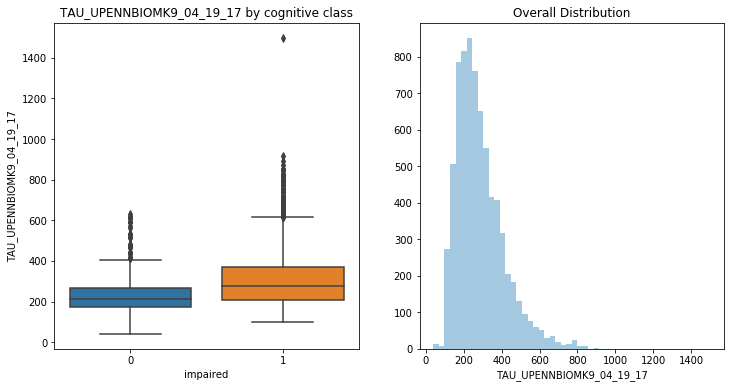

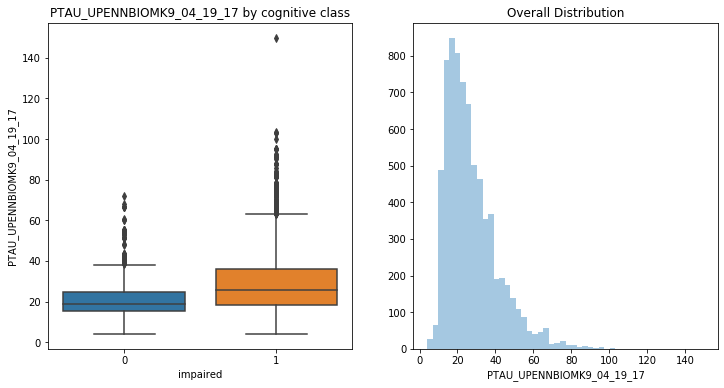

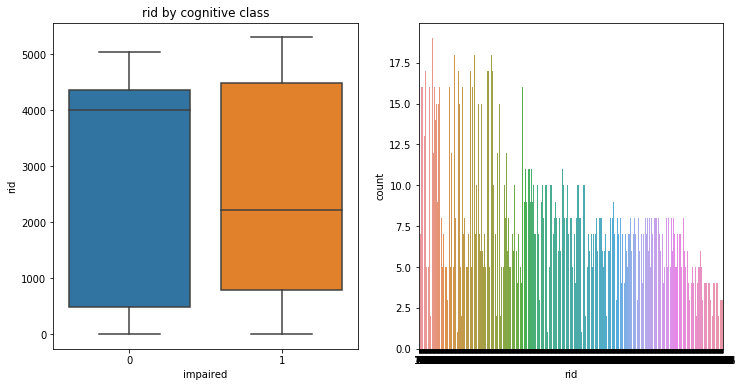

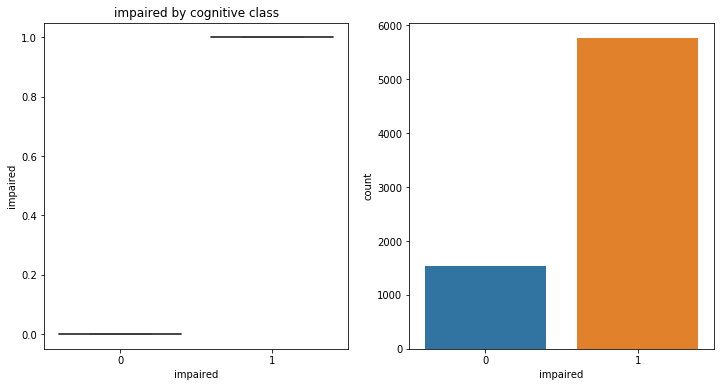

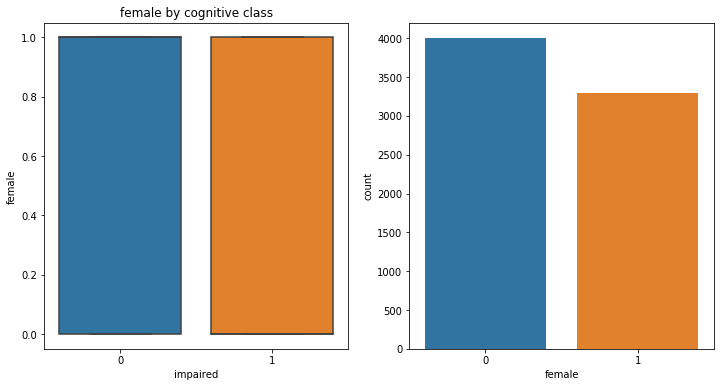

  t-test on:0  AGE                         difference in means +1.69     Ttest_indResult(statistic=9.705924804415469, pvalue=5.997197171330581e-22)
fruit
  t-test on:1  APOE4                       difference in means -0.382    Ttest_indResult(statistic=-26.082408867623798, pvalue=9.30873553282031e-138)
fruit
  t-test on:2  CDRSB_bl                    difference in means -1.61     Ttest_indResult(statistic=-78.98909626509295, pvalue=0.0)
fruit
  t-test on:3  ADAS11_bl                   difference in means -4.89     Ttest_indResult(statistic=-45.756319830467405, pvalue=0.0)
fruit
  t-test on:4  MMSE_bl                     difference in means +1.77     Ttest_indResult(statistic=41.068573339211945, pvalue=0.0)
fruit
  t-test on:5  RAVLT_immediate_bl          difference in means +11.2     Ttest_indResult(statistic=38.71958010548803, pvalue=3.907898501305535e-264)
fruit
  t-test on:6  RAVLT_learning_bl           difference in means +1.86     Ttest_indResult(statistic=27.77622157700926, pvalu

In [58]:
for i in t2.columns:
    plt.subplots(figsize=(12,6))
    plt.subplot(1,2,1,)
    sns.boxplot(y=t2[i], x = t2.impaired, data = t2)
    plt.title(str(i) + " by cognitive class")
    plt.subplot(1,2,2)
    if t2[i].dtype == ("float64" or "int64"):
        sns.distplot(t2[i], kde=False )
        plt.title("Overall Distribution")
        
    else:
        sns.countplot(x=i, data = t2)
        
    plt.show()
    
for c,v in enumerate(ts.get_group(0).columns):
    m = ts.get_group(0)[v].mean() - ts.get_group(1)[v].mean()
    tango = scipy.stats.ttest_ind(ts.get_group(0)[v], ts.get_group(1)[v], axis=0, equal_var=False, nan_policy='propagate')
    mango = "fruit"
    #mango = scipy.stats.chisquare(f_obs=ts.get_group(1)[v], f_exp=ts.get_group(0)[v])
    line_new = '{:>12}{:<3}{:<28}{} {:<+9.3} {}'.format("t-test on:", c, v, "difference in means", m, tango)
    print(line_new)
    print(mango)
    

In [59]:
# number of patients (not data points) in each group
ts.rid.nunique()
    

impaired
0    187
1    799
Name: rid, dtype: int64

In [60]:
v = "female"
mango = scipy.stats.chisquare(f_obs=ts.get_group(1)[v]., f_exp=ts.get_group(0)[v])

SyntaxError: invalid syntax (<ipython-input-60-b06fe0358843>, line 2)

In [ ]:
learn = np.arange(40,260,20)
for n in learn:
    t_mod = TSNE(learning_rate=n)
    t_feat = t_mod.fit_transform(t2)
    sns.scatterplot(data=t_feat, hue=t2.impaired)
    t_str = "TSNE learning rate: " + str(n)
    plt.title(t_str)
    plt.show()